# Bayesian differential abundance testing

In [592]:
library(tidyverse)
library(glue)
library(brms)
library(furrr)
library(here)
library(future)
library(tidybayes)
# load data and helper functions
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/bayesian_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/mb_helper.R")
source("https://raw.githubusercontent.com/HenrikEckermann/in_use/master/reporting.R")

In [593]:
load(here("rdata/data_mi.rds"))

In [594]:
# define the formula we use at the example of Bifidobacterium
formula_mu <- glue("Bifidobacterium ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
formula_sigma <- sigma ~ 1 + time*cc
formula <- bf(formula_mu, formula_sigma)
# see default priors brms
get_prior(formula, data = data_imp[[1]], family = student)
# we use default prior except for using a normal(0, 1) prior for the b
# which makes the model more skeptical of large effect sizes

prior,class,coef,group,resp,dpar,nlpar,bound
"student_t(3, 7, 10)",Intercept,,,,,,
,b,,,,,,
,b,age_d_s,,,,,
,b,bf_count_s,,,,,
,b,ccyes,,,,,
,b,csection1,,,,,
,b,sibling1,,,,,
,b,sibling1:csection1,,,,,
,b,timepost,,,,,
,b,timepost:ccyes,,,,,


In [611]:
genera <- c(
    "Bifidobacterium", 
    "Enterococcus", 
    "Streptococcusbovisetrel", 
    "Streptococcusmitisetrel", 
    "Streptococcusintermediusetrel",
    "Granulicatella"
)

In [603]:
genera <- colnames(data_imp[[1]])[29:158]

In [ ]:
models <- map(test_genus, function(genus) {
    formula_mu <- glue("{genus} ~ time*cc + age_d_s + bf_count_s + sibling*csection + (1|subject_id)") %>% as.formula()
    formula_sigma <- sigma ~ 1 + time*cc
    formula <- bf(formula_mu, formula_sigma)
    
    # fit example model
    fit <- brm(
        data = data_imp[[1]],
        family = student(),
        formula = bf(formula_mu, formula_sigma),
        prior = c(prior(normal(0, 1), class = b),
                  prior(normal(0, 4), class = Intercept, dpar = sigma),
                  prior(normal(0, 0.2), class = b, dpar = sigma), 
                  prior(gamma(2, 0.2), class = nu)),
        cores = 4,
        file = here(glue("models/test_{genus}_tt"))
    ) 
})v

In [529]:
nd <- with(data_imp[[1]], 
           expand.grid(cc = levels(cc), time = levels(time),
                       sibling = levels(sibling), csection = levels(csection)))
nd$bf_count_s <- median(model.frame(fit_t)$bf_count_s)
nd$age_d_s <- median(model.frame(fit_t)$age_d_s)
nd$bf_count_s <- 0
nd$age_d_s <- 0

In [629]:
plinps <- map(models, function(fit) {
    plinp <- posterior_linpred(fit, nd, transform = T,  re.form = ~ 0) %>% as_tibble()
    colnames(plinp) <- c(
        "home_pre_nosib_nocsec",
        "cc_pre_nosib_nocsec",
        "home_post_nosib_nocsec",
        "cc_post_nosib_nocsec",
        "home_pre_sib_nocsec",
        "cc_pre_sib_nocsec",
        "home_post_sib_nocsec", 
        "cc_post_sib_nocsec",
        "home_pre_nosib_csec",
        "cc_pre_nosib_csec", 
        "home_post_nosib_csec",
        "cc_post_nosib_csec",
        "home_pre_sib_csec",
        "cc_pre_sib_csec",
        "home_post_sib_csec",
        "cc_post_sib_csec"
    )
    plinp
})

In [636]:
# comparisons 
comparisons <- map2(plinps, genera, function(df, genus) {
    comparisons <- df %>%
        mutate(
            genus = genus, 
            
            # ccpre vs homepre (without csec)
            homepre = (home_pre_nosib_nocsec + home_pre_sib_nocsec)/2,
            ccpre = (cc_pre_nosib_nocsec + cc_pre_sib_nocsec)/2,
            ccpre_homepre = ccpre - homepre,
            
            # ccpost vs ccpre
            ccpost = (cc_post_nosib_nocsec + cc_post_sib_nocsec)/2,
            ccpost_ccpre = ccpost -ccpre,
            
            # ccpost vs homepost
            homepost = (home_post_nosib_nocsec + home_post_sib_nocsec)/2,
            ccpost_homepost = ccpost - homepost,
            
            # homepost vs homepre
            homepost_homepre = homepost - homepre,
            
            # sibling (if csec: home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)
            nosib = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec)/4,
            sib = (home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/4,
            sib_nosib = sib - nosib,
            
            # csec
            nocsec = (home_pre_nosib_nocsec + cc_pre_nosib_nocsec + home_post_nosib_nocsec + cc_post_nosib_nocsec +
                      home_pre_sib_nocsec + cc_pre_sib_nocsec + home_post_sib_nocsec + cc_post_sib_nocsec)/8,
            csec = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec +
                      home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/8,
            csec_nocsec = csec - nocsec,
            
            # sib * csec
            csec_sib = (home_pre_sib_csec + cc_pre_sib_csec + home_post_sib_csec + cc_post_sib_csec)/4,
            csec_nosib = (home_pre_nosib_csec + cc_pre_nosib_csec + home_post_nosib_csec + cc_post_nosib_csec)/4,
            csecsib_csecnosib = csec_sib - csec_nosib
        ) %>%
    select(genus, ccpre_homepre, ccpost_ccpre, ccpost_homepost, homepost_homepre, sib_nosib, csec_nocsec, csecsib_csecnosib)
})
comparisons <- map_dfr(comparisons, bind_rows)

In [649]:
comparisons %>% head()

genus,ccpre_homepre,ccpost_ccpre,ccpost_homepost,homepost_homepre,sib_nosib,csec_nocsec,csecsib_csecnosib
Bifidobacterium,-0.070199325,0.37061765,0.22175371,0.07866461,0.07514909,-0.4265650,1.0193276
Bifidobacterium,0.162848963,0.06869383,0.17939315,0.05214964,-0.19678362,-0.5068161,0.3359486
Bifidobacterium,-0.088982589,0.33282191,0.07901321,0.16482612,0.06862222,-0.1592189,0.2314678
Bifidobacterium,0.113452179,0.12290496,0.09357791,0.14277923,0.06732507,-0.5013273,0.4611338
Bifidobacterium,0.002568185,0.31179974,0.32479025,-0.01042232,0.08187343,-0.4398694,1.0060732
Bifidobacterium,0.140086961,0.48221851,0.17122419,0.45108128,0.04487236,-0.6132460,0.7777583


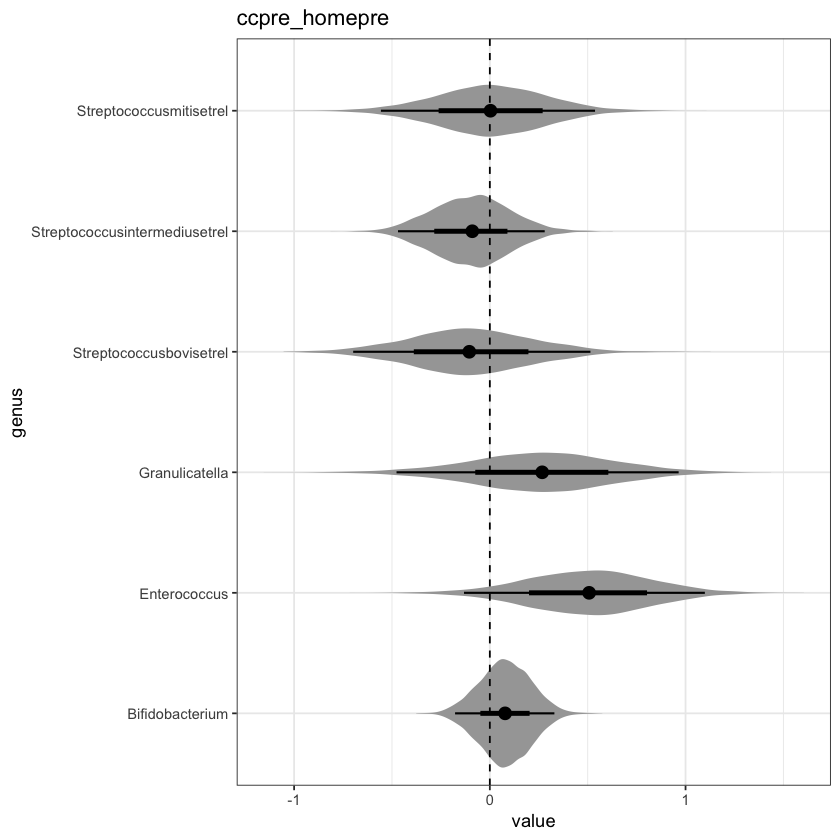

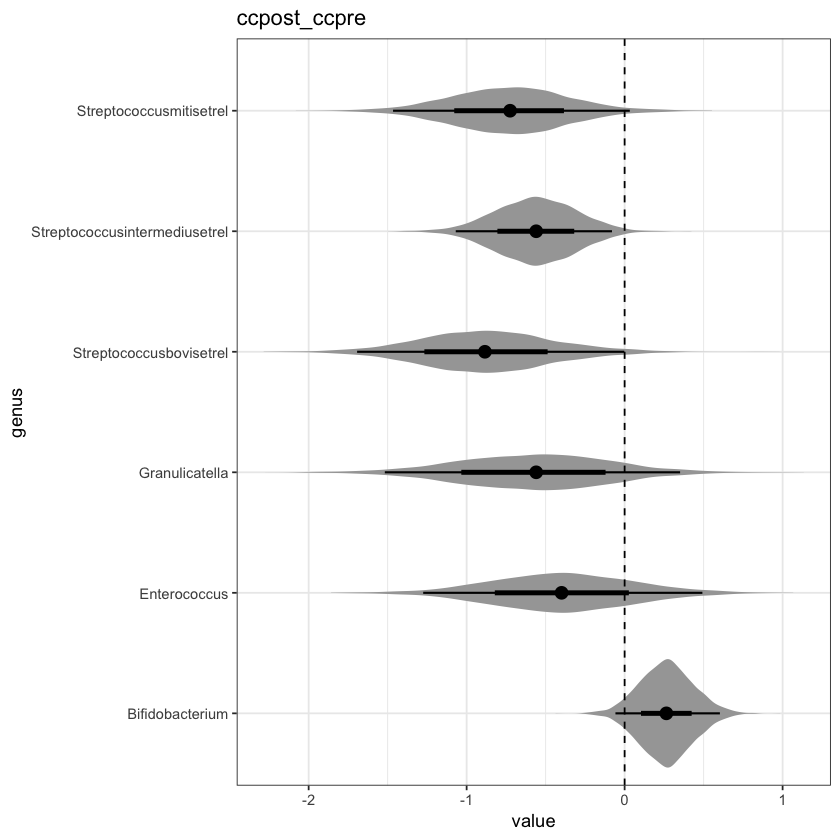

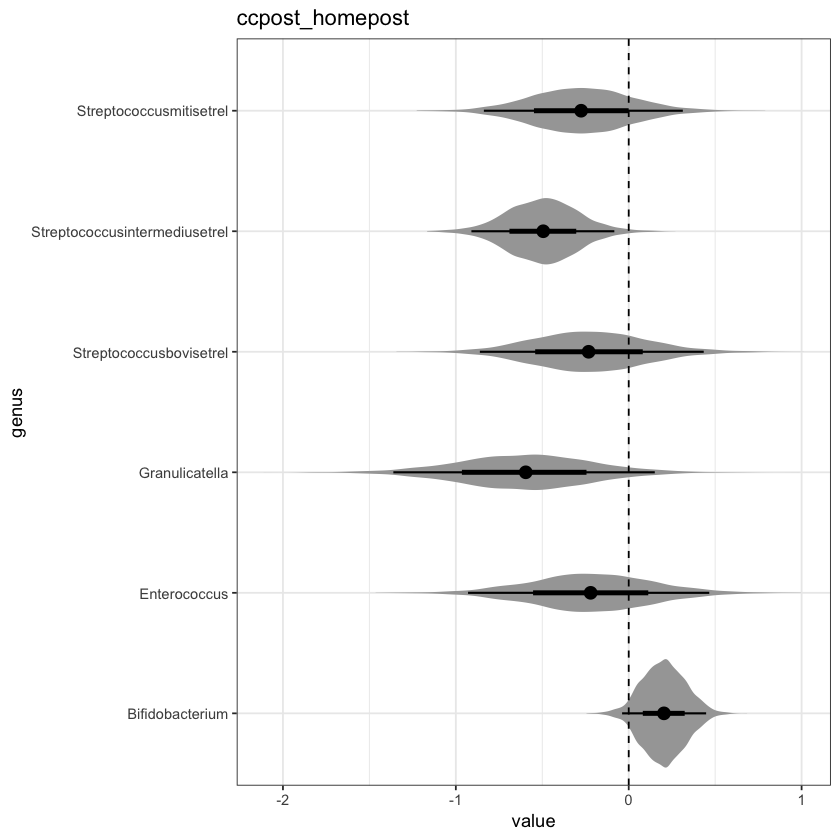

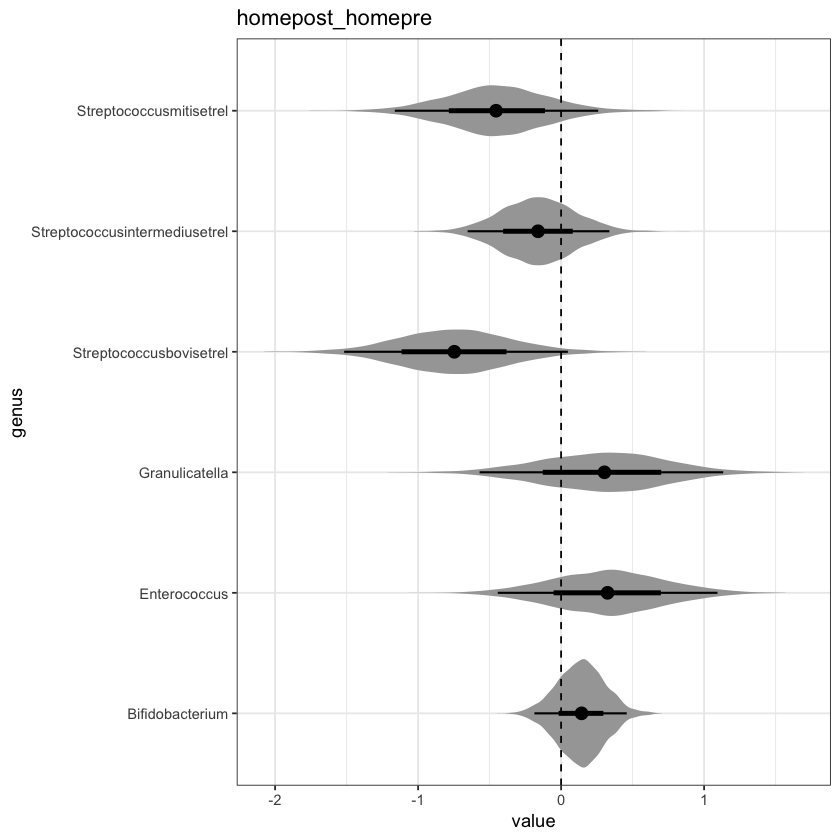

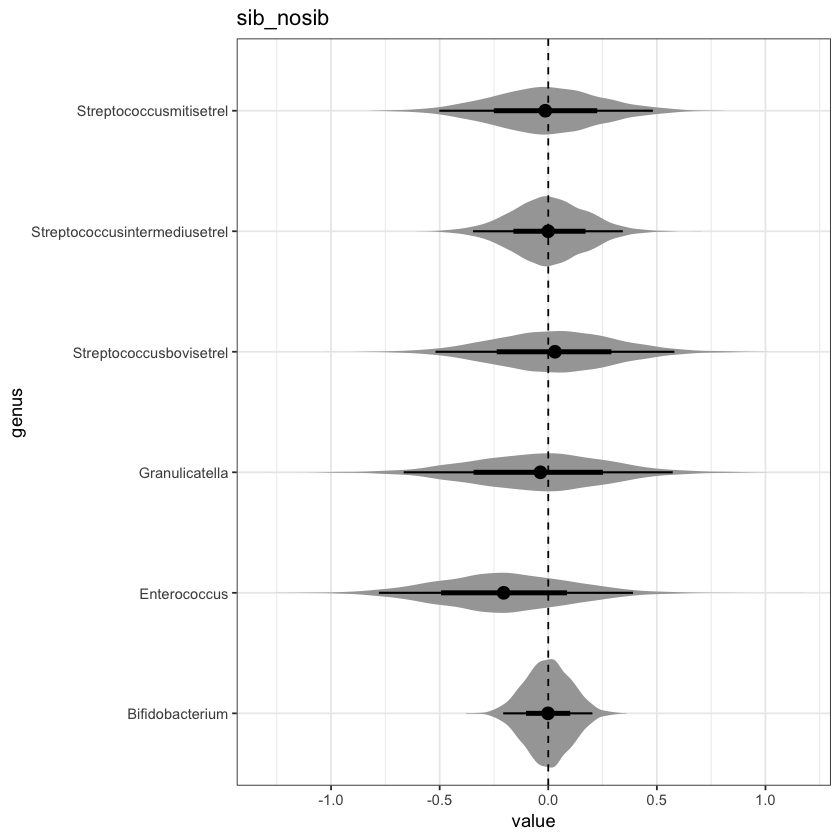

[[1]]

[[2]]

[[3]]

[[4]]

[[5]]

[[6]]

[[7]]


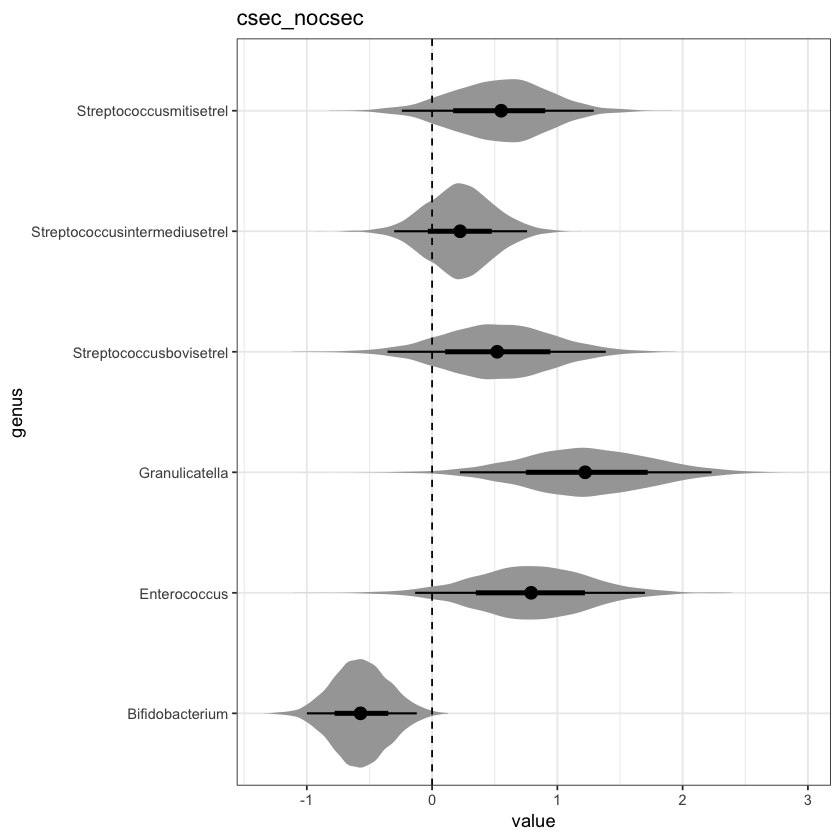

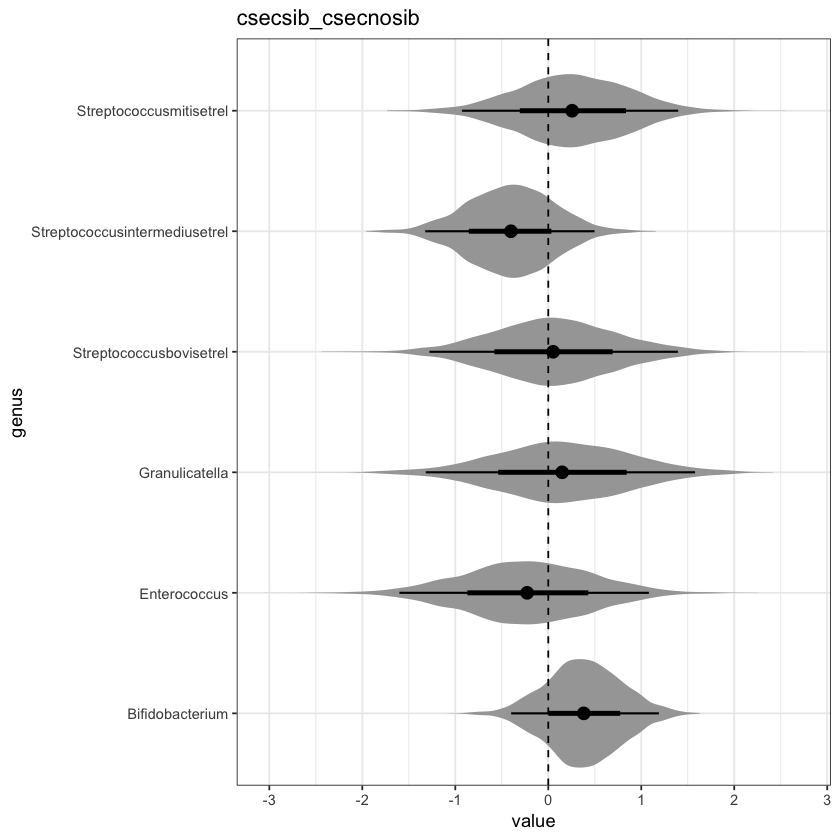

In [654]:
comparisons_nest <- comparisons %>% 
    gather(comparison, value, -genus) %>%
    group_by(comparison) %>%
    nest()


map2(comparisons_nest$data, comparisons_nest$comparison, function(df, comparison) {
    df %>% 
    ggplot(aes(value, genus)) +
        geom_eyeh() +
        geom_vline(aes(xintercept = 0), linetype = "dashed") +
        theme_bw() +
        ggtitle(comparison)
})

In [587]:
plinp %>% head()
plinp %>% mutate(
            homepre = (home_pre_nosib_nocsec + home_pre_nosib_csec + home_pre_sib_nocsec + home_pre_sib_csec)/4,
            homepost = (home_post_nosib_nocsec + home_post_nosib_csec + home_post_sib_nocsec + home_post_sib_csec)/4,
            ccpre = (cc_pre_nosib_nocsec + cc_pre_nosib_csec + cc_pre_sib_nocsec + cc_pre_sib_csec)/4,
            ccpost = (cc_post_nosib_nocsec + cc_post_nosib_csec + cc_post_sib_nocsec + cc_post_sib_csec)/4) %>%
    mutate(ccpost_homepost = ccpost - homepost,
           ccpost_ccpre = ccpost -ccpre,
           ccpre_homepre = ccpre - homepre) %>%
    select(ccpost_homepost, ccpost_ccpre, ccpre_homepre) %>%
    gather(comparison, value) %>%
    group_by(comparison) %>%
    mean_hdi()
plinp %>% gather(subgroup, value) %>%
    group_by(subgroup) %>%
    mean_hdi()

home_pre_nosib_nocsec,cc_pre_nosib_nocsec,home_post_nosib_nocsec,cc_post_nosib_nocsec,home_pre_sib_nocsec,cc_pre_sib_nocsec,home_post_sib_nocsec,cc_post_sib_nocsec,home_pre_nosib_csec,cc_pre_nosib_csec,home_post_nosib_csec,cc_post_nosib_csec,home_pre_sib_csec,cc_pre_sib_csec,home_post_sib_csec,cc_post_sib_csec
6.373291,6.303092,6.451956,6.673709,6.448440,6.378241,6.527105,6.748858,5.474637,5.404437,5.553301,5.775055,6.493964,6.423765,6.572629,6.794383
6.528292,6.691141,6.580442,6.759835,6.331509,6.494358,6.383658,6.563051,5.755110,5.917959,5.807260,5.986653,6.091059,6.253908,6.143208,6.322601
6.357377,6.268394,6.522203,6.601216,6.425999,6.337016,6.590825,6.669838,6.116735,6.027752,6.281561,6.360574,6.348203,6.259220,6.513029,6.592042
6.430225,6.543677,6.573004,6.666582,6.497550,6.611002,6.640329,6.733907,5.731993,5.845445,5.874772,5.968350,6.193127,6.306579,6.335906,6.429484
6.488577,6.491146,6.478155,6.802945,6.570451,6.573019,6.560029,6.884819,5.586608,5.589176,5.576186,5.900976,6.592681,6.595250,6.582259,6.907049
6.295444,6.435531,6.746525,6.917750,6.340316,6.480403,6.791398,6.962622,5.315755,5.455842,5.766836,5.938061,6.093513,6.233600,6.544595,6.715819


comparison,value,.lower,.upper,.width,.point,.interval
ccpost_ccpre,0.26508388,-0.06625555,0.5905809,0.95,mean,hdi
ccpost_homepost,0.20329840,-0.02673416,0.4562393,0.95,mean,hdi
ccpre_homepre,0.07855331,-0.16994561,0.3361801,0.95,mean,hdi


subgroup,value,.lower,.upper,.width,.point,.interval
cc_post_nosib_csec,6.020067,5.522403,6.559627,0.95,mean,hdi
cc_post_nosib_nocsec,6.779922,6.467064,7.051430,0.95,mean,hdi
cc_post_sib_csec,6.403356,5.733381,7.072755,0.95,mean,hdi
cc_post_sib_nocsec,6.778711,6.531174,7.017748,0.95,mean,hdi
cc_pre_nosib_csec,5.754984,5.233303,6.257350,0.95,mean,hdi
cc_pre_nosib_nocsec,6.514838,6.295933,6.734481,0.95,mean,hdi
cc_pre_sib_csec,6.138272,5.434592,6.803722,0.95,mean,hdi
cc_pre_sib_nocsec,6.513627,6.271836,6.739362,0.95,mean,hdi
home_post_nosib_csec,5.816769,5.301503,6.350225,0.95,mean,hdi
home_post_nosib_nocsec,6.576624,6.320025,6.823365,0.95,mean,hdi


In [572]:
post %>% filter(genus == "Bifidobacterium") %>% 
    select(-genus) %>%
    gather(subgroup, value) %>%
    group_by(subgroup) %>%
    mean_hdi()


subgroup,value,.lower,.upper,.width,.point,.interval
ccpost_ccpre,0.14033878,-0.1849512,0.4600204,0.95,mean,hdi
ccpost_homepost,0.03217987,-0.2211741,0.2833221,0.95,mean,hdi
ccpre_homepre,0.03217987,-0.2211741,0.2833221,0.95,mean,hdi
csec,6.34413182,6.2040526,6.4685775,0.95,mean,hdi
csec_nocsec,0.19954053,0.1237707,0.2740804,0.95,mean,hdi
homepost_homepre,0.14033878,-0.1849512,0.4600204,0.95,mean,hdi
nocsec,6.54367235,6.4205433,6.6658707,0.95,mean,hdi


In [552]:
posterior_samples(models[1])  %>% select(b_ccyes, b_sibling1, b_csection1) %>% summarise_all(c(mean, sd))

b_ccyes_fn1,b_sibling1_fn1,b_csection1_fn1,b_ccyes_fn2,b_sibling1_fn2,b_csection1_fn2
0.07855331,-0.001210902,-0.7598546,0.1308462,0.1057739,0.2637425


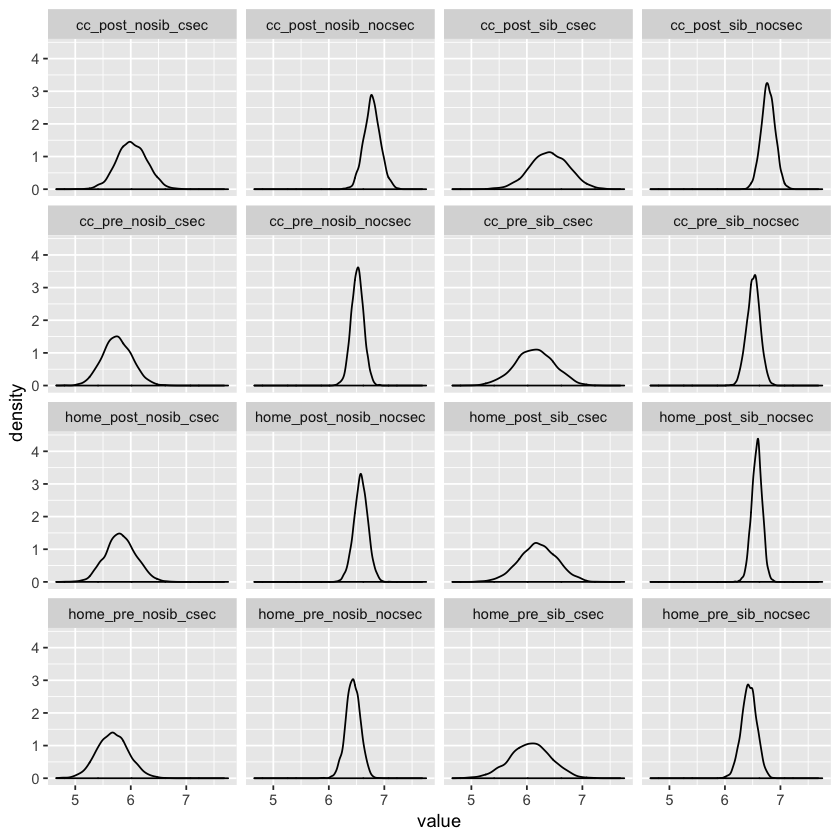

In [591]:
plinp %>% gather() %>%
    ggplot(aes(value)) +
    geom_density() +
    facet_wrap(~key)